# translating matlab code parser

## setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import time

from itertools import groupby

from tqdm import tqdm_notebook, tnrange

## params

In [2]:
# paths
#lvm_path = Path(r'data/qim_20kbps_10db_l2_v2.lvm')
lvm_path = Path(r'data/test_packet.txt')

# signal specific params
spb = 20

## class building

In [38]:
class DataParserLVM:
    def __init__(self, lvm_path, source='txt', header=None, preprocess_mode='static'):
        print('initializing..')
        
        # set input path
        if isinstance(lvm_path, Path):
            try: 
                assert lvm_path.exists()
                self.lvm_path = lvm_path
                print(f'\tset input lvm path: {self.lvm_path}')
            except AssertionError:
                print(f'no file found at {lvm_path}')
                raise                
        else:
            print(f'invalid path {lvm_path}, must be pathlib.Path object')
            raise TypeError
                
        # header
        if header is None:
            self.header = np.array([1 if i % 2 == 0 else 0 for i in range(30)])
            print(f'\tset header: {self.header}')
        else:
            if isinstance(header, list):
                self.header = np.array(header)
                print(f'\tset header: {self.header}')
            elif isinstance(header, np.array):
                self.header = header
                print(f'\tset header: {self.header}')
            else:
                print(
                    f'invalid header format specified ({type(header)}), ' + 
                    f'must be np.array or list'
                )
                raise TypeError
        
        # source
        if source == 'txt':
            self.parse_other_file()
        elif source == 'lvm':
            self.parse_lvm_file()
            self.read_csv_data()
        else:
            print(
                f'invalid source {source}, options are ' + 
                '\'txt\' for tab delimited numbers only or ' + 
                '\'lvm\' for lvm file with headers'
            )        
        
        # startup tasks
        self.preprocess_data(mode=preprocess_mode)
        
        
    def parse_other_file(self):
        print('parsing tab delimited file..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter='\t',
            usecols=(1)
        )        
        print(f'\timported data, {self.raw_data.size} rows')
        
            
    def parse_lvm_file(self, output_path='auto'):
        """
        reads in .lvm file, writes out .csv with column names
        containing only data points
        
        [arguments]
        input_path: str or pathlib.Path object (preferred)
            input file path
        output_path: 'auto' (preferred) or str or pathlib.Path object
            if auto:
                appends _parsed.csv to end of input file name
            else:
                use provided path, must end in .csv
                
        [returns]
        None
            outputs parsed lvm file
            sets self.parsed_lvm_path, pathlib.Path object pointing to parsed file
        """
        
        print('parsing lvm file..')
        with open(self.lvm_path, 'r') as infile:
            # set output path
            file_name = infile.name
            
            if output_path == 'auto':
                self.parsed_lvm_path = Path(f'{file_name}_parsed.csv')
            else:
                self.parsed_lvm_path = output_path
                
                if isinstance(parsed_lvm_path, Path):
                    try:
                        assert str(parsed_lvm_path).endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                elif isinstance(parsed_lvm_path, str):
                    try:
                        assert parsed_lvm_path.endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                else:
                    print('error, output_path must be str or pathlib.Path object')
                    raise TypeError
            
            if not self.parsed_lvm_path.exists():
                self.parsed_lvm_path.touch()
            
            # find header, store column names
            while True:
                line = infile.readline()
                
                if line.strip().endswith('Comment'):
                    cols = line.split(',')[:-1]
                    print(f'\tcolumns: {cols}')
                    break        
                    
            # trim file and write out
            with open(self.parsed_lvm_path, 'w') as outfile:
                outfile.write(', '.join(cols) + '\n')
                while True:
                    try:
                        outfile.write(next(infile))
                    except StopIteration:
                        break
        
        print(f'\tcomplete, parsed file saved to: {self.parsed_lvm_path}')
        
    def read_csv_data(self):
        print('importing data from parsed csv..')
        self.raw_data = np.genfromtxt(
            self.parsed_lvm_path,
            delimiter=',',
            skip_header=1,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
        
    def preprocess_data(self, mode='static'):
        """
        convert float data into 1's and 0's
        
        static: use 1/2 * max data point as threshold
        dynamic: use min + 1/2(max - min) as threshold
        """
        
        if mode == 'static':
            th = self.raw_data.max() / 2
        elif mode == 'dynamic':
            th = self.raw_data.min() + (self.raw_data.max() - self.raw_data.min()) / 2
        else:
            print(f'invalid mode {mode}, options are \'static\' or \'dynamic\'')        
        
        shape_check = self.raw_data[np.where(self.raw_data >= th)].size
        
        self.raw_data[np.where(self.raw_data >= th)] = 1
        self.raw_data[np.where(self.raw_data < th)] = 0
        
        # set dtype and store
        self.data = self.raw_data.astype('int')[7:]
        
        # validate
        try:
            assert self.data.sum() == shape_check            
        except AssertionError:
            print(
                f'error: sum of 1\'s ({self.data.sum()}) does not match ' + 
                f'number of entries >= th ({shape_check})'
            )
        
        
    def get_state_length_list(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
        of duration of consecutive bits ([13,245,2588,19,1056,...])
        '''
        
        return np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
    
    def get_correct_state_length_list(self, data):
        '''
        gets state lengths like above, but correctly..
        '''
        
        groups = groupby(data)
        
        return [sum(1 for _ in group) for _, group in groups]
    

    def discretize_signal(self, spb):
        start_time = time.time()
        print('discretizing signal..')
        
        # set params
        self.spb = spb
        
        discretized_data = []
        start_bit = self.data[0]
        alt_bit = 0 if start_bit == 1 else 1
        print(f'\tstarting bit: {start_bit}, alt bit: {alt_bit}')
        
        # get state lengths
        #state_lengths = self.get_state_length_list(self.data)
        state_lengths = self.get_correct_state_length_list(self.data)
        
        for i, state in enumerate(state_lengths):
            discretized_state = int(np.round(state / self.spb))
            #print(f'iter: {i}, discretized state: {discretized_state}')
            
            if i % 2 == 0:
                discretized_data.append([start_bit for j in range(discretized_state)])
            elif i % 2 == 1:
                discretized_data.append([alt_bit for j in range(discretized_state)])
            else:
                print('ya done messed up.')
        
        self.discretized_array = np.array([
            item for sublist 
                in discretized_data 
            for item in sublist
        ])
        
        reduction = 100 * (self.discretized_array.size / self.data.size)
        print(
            f'\tcomplete, discretized signal: {self.discretized_array.size} entries ' + 
            f'({reduction:0.2f}% of original)\n'
            f'\tprocessing time: {time.time() - start_time:0.4f} sec, hot damn.'
        )
        

    def search_sequence_numpy(self, arr, seq):
        """ 
        find sequence in an array 
    
        Parameters
        ----------    
        arr    : input 1D array
        seq    : input 1D array
    
        Output
        ------    
        Output : 1D Array of indices in the input array that satisfy the 
        matching of input sequence in the input array.
        In case of no match, an empty list is returned.
        """
    
        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size
    
        # Range of sequence
        r_seq = np.arange(Nseq)
    
        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)
    
        # Get the range of those indices as final output
        if M.any() >0:
            return np.where(
                np.convolve(
                    M,
                    np.ones((Nseq), dtype=int)
                ) > 0
            )[0]
        else:
            return []  
        
    
    def output_discretized_array(self, output_path='auto', output_format='csv'):
        # set output path
        if output_path == 'auto':
            output_path = Path(r'data/discretized_array.csv')            
        elif isinstance(output_path, Path):
            try:
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        elif isinstance(output_path, str):
            try:
                output_path = Path(output_path)
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        else:
            print(
                f'you really messed up, you provided {output_path} {type(output_path)}, ' + 
                f'please provide output_path as str or pathlib.Path object ending with .csv'
            )            
        print(f'set discretized signal output path: {output_path}')
                
        # output
        if output_format == 'csv':
            np.savetxt(
                output_path,
                self.discretized_array,
                delimiter=','
            )
            print(f'\tsuccessfully saved file to: {output_path}')
        else:
            print(f'yeah.. csv is actually the only option.. please try again.')
            raise TypeError
    
    
    
    def main(self):
        self.discretize_signal()
        
        
        

In [39]:
DP = DataParserLVM(
    lvm_path, 
    source='txt',
    preprocess_mode='dynamic'
)

initializing..
	set input lvm path: data\test_packet.txt
	set header: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
parsing tab delimited file..
	imported data, 3500000 rows


In [ ]:
DP.discretize_signal(spb=12)

In [ ]:
DP.discretized_array[:50]

## spb explorating

### minimum and frequencies

In [ ]:
from collections import Counter

In [ ]:
DP.data.size

In [ ]:
state_lengths = DP.get_state_length_list(DP.data)

In [ ]:
state_lengths[:20]

In [ ]:
state_freqs = Counter(state_lengths)

In [ ]:
(pd
 .DataFrame(
     state_freqs.most_common(), 
     columns=['length','frequency']
 )
 .set_index('length')
 .sort_index()
 .plot
 .bar()
);

### spb iter exploration

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 702476 entries (20.07% of original)
	processing time: 1.5599 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 583337 entries (16.67% of original)
	processing time: 1.5809 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 495910 entries (14.17% of original)
	processing time: 1.5722 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 437503 entries (12.50% of original)
	processing time: 1.6850 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 390623 entries (11.16% of original)
	processing time: 1.5927 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 326538 entries (9.33% of original)
	processing time: 1.4699 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 297210 entries (8.49% of original)
	processing time: 1.4780 sec, hot damn.


None

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 291668 entries (8.33% of original)
	processing time: 1.5762 sec, hot damn.


None

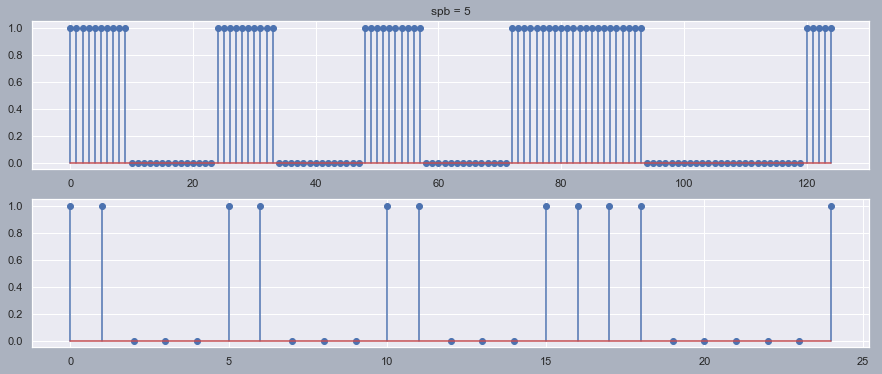

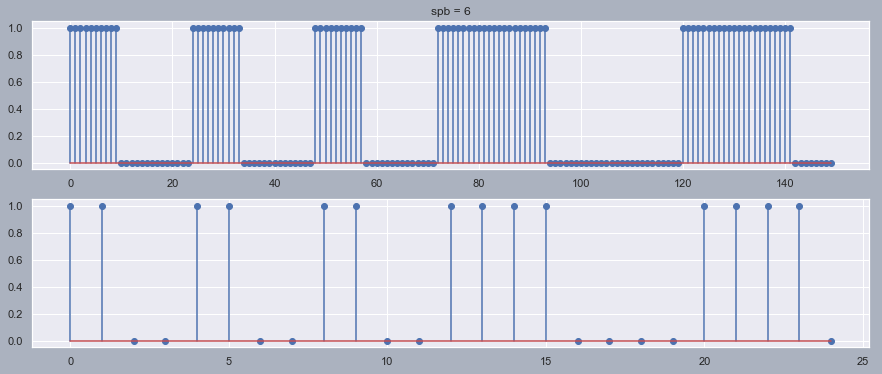

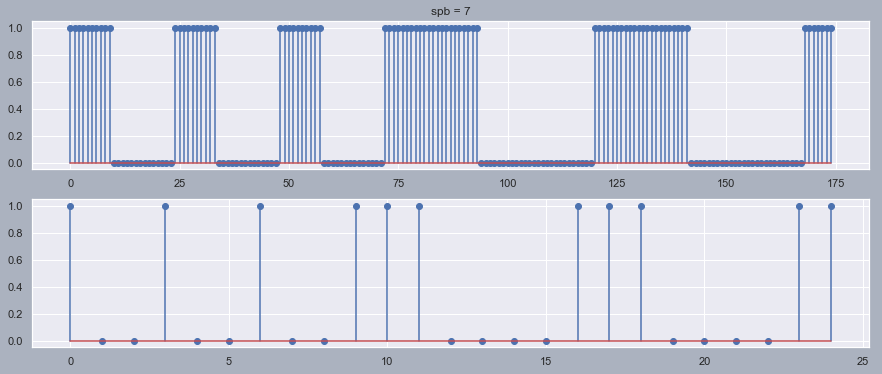

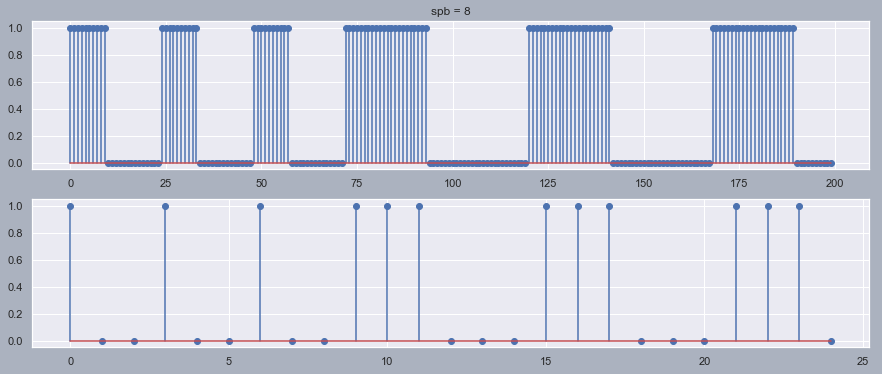

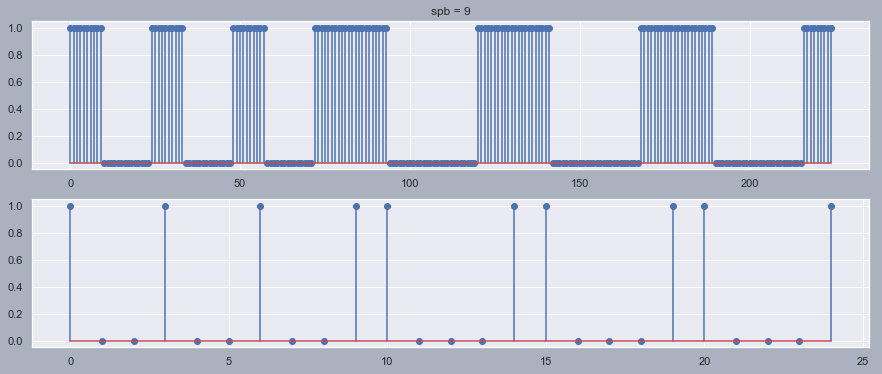

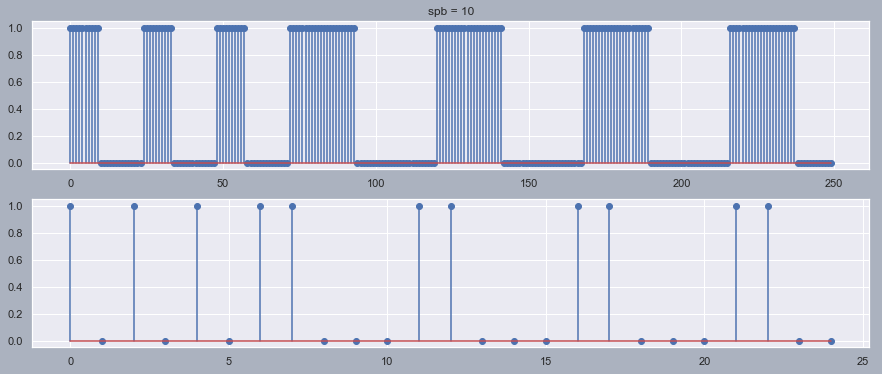

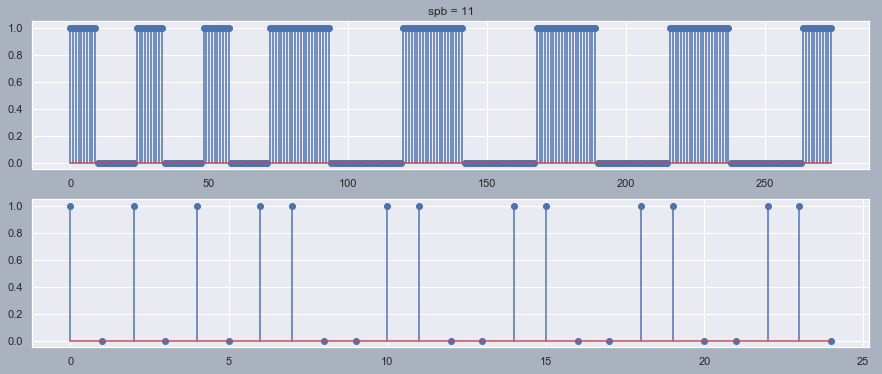

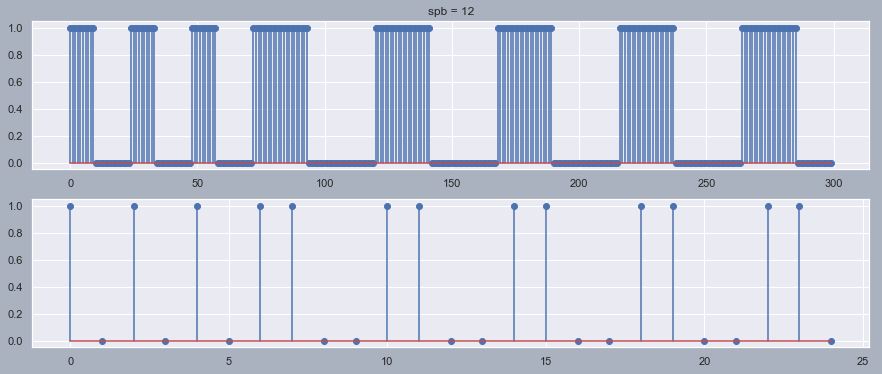

In [45]:
spb_list = [i for i in range(5, 13, 1)]

for spb in spb_list:
    DP.discretize_signal(spb)
    display(compare_plots(0, 25, title=f'spb = {spb}'))

### viz

In [ ]:
compare_plots(0, 50)

In [ ]:
plot_subset(DP.data, 0, 200)

In [ ]:
plot_subset(DP.discretized_array, 0, 20)

### state length debug

In [ ]:
%%time
groups = groupby(DP.data)

state_lengths = [sum(1 for _ in group) for _, group in groups]

In [40]:
def get_correct_state_length_list(data):
    groups = groupby(data)
    return [sum(1 for _ in group) for _, group in groups]

In [41]:
state_lengths = get_correct_state_length_list(DP.data)

In [42]:
state_lengths[:10]

[10, 14, 10, 14, 10, 14, 22, 26, 22, 26]

In [43]:
from collections import Counter
state_freqs = Counter(state_lengths)

In [44]:
state_freqs.most_common()

[(14, 39780),
 (10, 39722),
 (22, 19880),
 (26, 19877),
 (11, 14791),
 (13, 14733),
 (25, 7383),
 (23, 7380),
 (599, 1273),
 (49, 1190),
 (48, 173),
 (600, 90),
 (5, 1)]

## message search

In [ ]:
sample_rate = 200e3                         # samples / sec
sample_spacing = 1 / sample_rate            # sec / sample
scaler = 240e-6 / sample_spacing / DP.spb   # num samples

In [ ]:
scaler = 1

base = np.array([1 if i % 2 == 0 else 0 for i in range(20)])

data_msg = np.concatenate((
    np.repeat(base, scaler), 
    np.repeat(base, 2*scaler), 
    np.repeat(base, scaler), 
    np.repeat(base, 2*scaler)
))

print(data_msg.size)
data_msg

In [ ]:
data_msg[:20]

In [ ]:
DP.search_sequence_numpy(
    DP.discretized_array,
    data_msg
)

In [ ]:
scaler_dict = {}

for scaler in tnrange(1,50,1):
    data_msg = np.concatenate((
        np.repeat(base, scaler), 
        np.repeat(base, 2*scaler), 
        np.repeat(base, scaler), 
        np.repeat(base, 2*scaler)
    ))
    
    scaler_dict[scaler] = DP.search_sequence_numpy(
        DP.discretized_array,
        data_msg
    )

In [ ]:
scaler_dict

In [ ]:
[
    (scaler, len(matches))
    for scaler, matches in scaler_dict.items()
]

## visualiziation 

In [8]:
# seaborn with custom background
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

### plot subset

In [6]:
def plot_subset(data, start, stop):
    plt.figure(figsize=(20, 6))
    
    plt.stem(data[start:stop])

### discretized vs real

In [18]:
def compare_plots(start, stop, title):
    fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15,6))
    
    ax1.stem(DP.data[start*DP.spb:stop*DP.spb])
    ax2.stem(DP.discretized_array[start:stop]) 
    
    ax1.set_title(title)
    

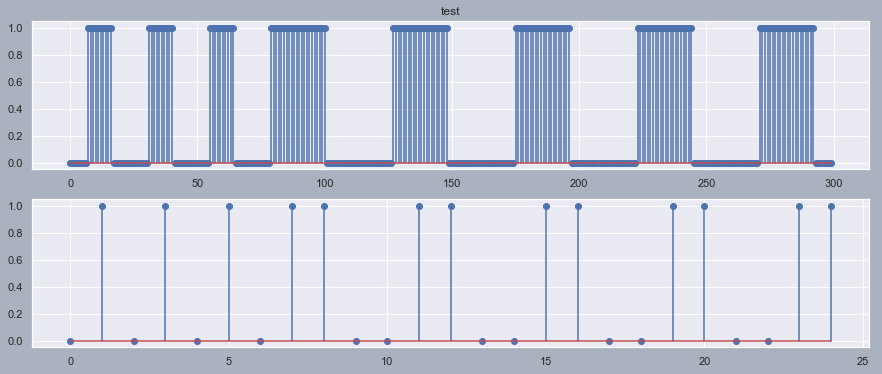

In [17]:
compare_plots(0, 25)

In [ ]:
compare_plots(150, 200)

In [ ]:
start = 1000
stop = 1100

In [ ]:
plt.figure(figsize=(25,6))
plt.stem(DP.raw_data[start*DP.spb:stop*DP.spb])

In [ ]:
plt.figure(figsize=(20,6))
plt.stem(DP.discretized_array[start:stop])

### spb brute force attempt

In [ ]:
from collections import Counter

In [ ]:
spb_list = [i for i in range(1, 50, 1)]
print(f'spb_list: {len(spb_list)} elements')

In [ ]:
result_dict = {}

for spb in tqdm_notebook(spb_list):
    DP.discretize_signal(spb)    
    
    result_dict[spb] = DP.search_sequence_numpy(
        DP.discretized_array, 
        DP.header
    )

In [ ]:
frequencies = {
    spb: Counter(np.diff(matches)).most_common(3)
    for spb, matches in result_dict.items()
}

frequencies